In [1]:
# important packages
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import statistics
import datetime as datatime
from time import time

import warnings
warnings.filterwarnings('ignore')

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sweetviz as sv

# data preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# pipeline
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline

# feature selection
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import RFECV

# train test split and cross validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# imbalanced data
from imblearn.over_sampling import SMOTE

# Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb
from ngboost import NGBClassifier
from sklearn.neural_network import BernoulliRBM
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier

# model evaluation
from sklearn import metrics

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import optuna

# 1. Data Import and Basic Data Checking

In [2]:
bids_df = pd.read_csv('data/bids.csv')
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

## 1a. Check bids_df

In [3]:
bids_df.head()

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
0,0,c6faf9e526c72bc8383f2bc4417a465d2fa27,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3
1,1,d96e93359ed70b7b4eebac163f448afeb50dc,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c
2,2,065bdcc596308d1fdd0014261d6e198aa138e,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3
3,3,e97aa310037dd210f52b5b164077a926bb5de,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,vasstdc27m7nks3
4,4,41a7f56fcc5771d305baa6e989fb2e8cceb21,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,vasstdc27m7nks3


### 1ai. Check missing data

In [4]:
bids_df.isnull().sum()

bid_id            0
bidder_id         0
auction           0
merchandise       0
device            0
time              0
country        8859
ip                0
url               0
dtype: int64

### 1aii. Fill country missing values with mode

In [5]:
bids_df['country'] = bids_df['country'].fillna(bids_df['country'].mode()[0])

## 1b. Check train_df

In [6]:
train_df.head()

,bidder_id,payment_account,address,outcome
0,4a791121f1d9c9c192d13051301984388c491,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0
1,6feeeab451fcc546e1c43867e04bd5d2294fc,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0
2,0bdfae6168380fa2e00853fd3d6199ba8ed7d,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0
3,3b4586382b3ff164e8bad37b15a268a540996,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0
4,10c7f4bdc67a50bab856b9ca76a83ce980f96,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0


### 1bi. Check missing data

In [7]:
train_df.isnull().sum()

bidder_id          0
payment_account    0
address            0
outcome            0
dtype: int64

## 1c. Check test_df

In [8]:
test_df.head()

,bidder_id,payment_account,address
0,b892f38403f2cc95c1ba1bf4f3b46d89505ea,a3d2de7675556553a5f08e4c88d2c228htx90,5d9fa1b71f992e7c7a106ce4b07a0a754le7c
1,77849f7bfc8bf29c595b50d3640bee1f2189b,a3d2de7675556553a5f08e4c88d2c228rs17i,a3d2de7675556553a5f08e4c88d2c228klidn
2,ef3e34da1e7470d99ed3ce8617e24b6b4541f,925381cce086b8cc9594eee1c77edf665zjpl,a3d2de7675556553a5f08e4c88d2c228aght0
3,7aeb6c9fda0c521f54111c47737e17543aaca,a3d2de7675556553a5f08e4c88d2c228nclv5,b5714de1fd69d4a0d2e39d59e53fe9e15vwat
4,6394924262e3b28e89822b95b170cde4240d8,a3d2de7675556553a5f08e4c88d2c228dtdkd,c3b363a3c3b838d58c85acf0fc9964cb4pnfa


### 1ci. Check missing data

In [9]:
test_df.isnull().sum()

bidder_id          0
payment_account    0
address            0
dtype: int64

# 2. Exploratory Data Analysis

### 2a. Create SweetViz Report

In [10]:
bids_df_report = sv.analyze(bids_df)
bids_df_report.show_html('bids_df.html')

                                             |                                             | [  0%]   00:00 ->…

Report bids_df.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [11]:
eda = bids_df.merge(train_df, on='bidder_id', how='left')

eda_report = sv.analyze(eda)
eda_report.show_html('eda.html')

                                             |                                             | [  0%]   00:00 ->…

Report eda.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [12]:
eda.isnull().sum()

bid_id                   0
bidder_id                0
auction                  0
merchandise              0
device                   0
time                     0
country                  0
ip                       0
url                      0
payment_account    4585110
address            4585110
outcome            4585110
dtype: int64

### 2b. Analyze Bots

In [13]:
bots_df = eda[eda['outcome'] == 1]

<b> It is noticed that 5 bots are only making 1 bid. Therefore, it is advisable to can drop these 5 bots ('48c528dd6dedf6bdadfeacda9b6df066c8c55', '5c3cf27bce8d533fc726754f01ce163b20337', '2137636448719ca7f3926f8b0df00d2b1ffbb', 'fe36527ed0bcd4ef063c5dfb6e9db7683e168', '52031dece42bc8602c0d7246f57f5c8bcbf69') from training data as they are anomolies. </b>

In [14]:
bots_df.groupby('bidder_id')['bid_id'].count().sort_values().head(10)

bidder_id
48c528dd6dedf6bdadfeacda9b6df066c8c55      1
5c3cf27bce8d533fc726754f01ce163b20337      1
2137636448719ca7f3926f8b0df00d2b1ffbb      1
fe36527ed0bcd4ef063c5dfb6e9db7683e168      1
52031dece42bc8602c0d7246f57f5c8bcbf69      1
b0fef9488c5883d8d6338fd4080eea23b2190      4
14c55e9c7c7304a27acb24884ef916bc42fde     10
b9bd6ca39a8e19e730845189f9ac254e56ba3    137
cf6d11d0bf1ed7ef07dd004365763d64b3daf    148
573d731e7592afdb0527eabe6891dfd870cbb    151
Name: bid_id, dtype: int64

<AxesSubplot:ylabel='Frequency'>

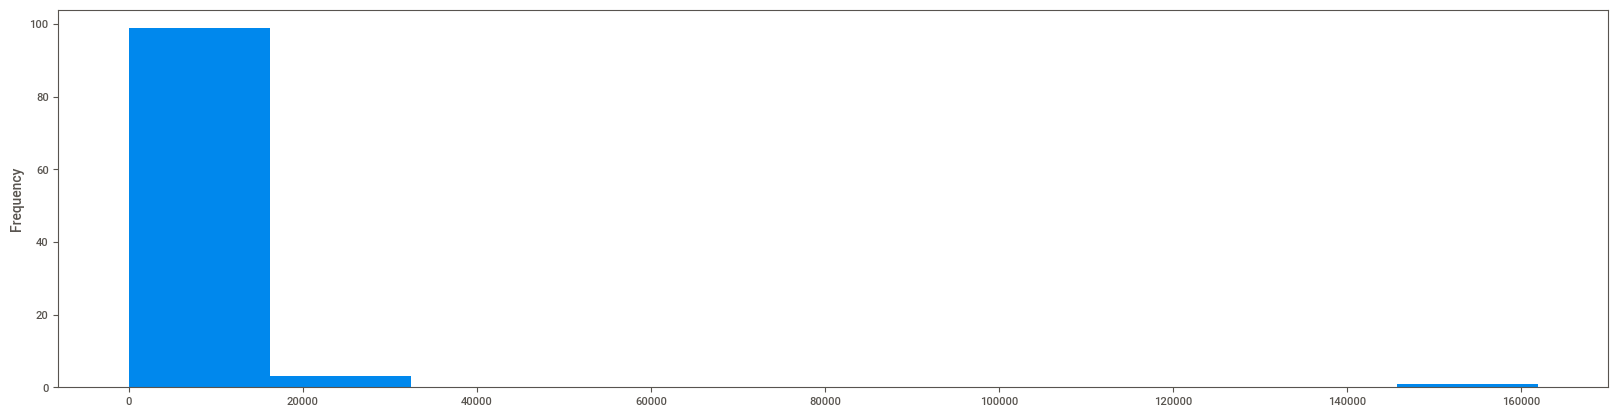

In [15]:
bots_df.groupby('bidder_id')['bid_id'].count().plot(kind = 'hist', figsize = (20,5))

# 3. Feature Engineering

## 3a. Adding more feature columns with `.nunique()`

<b>
i. Number of bids made per bidder_id <br>
ii. Number of auctions made per bidder_id <br>
iii. Number of merchandise made per bidder_id <br>
iv. Number of device made per bidder_id <br>
v. Number of countries originated per bidder_id <br>
vi. Number of ip addresses used per bidder_id <br>
vii. Number of url addresses used per bidder_id <br>
</b>

In [16]:
bids_df_cols = ['bid_id', 'bidder_id', 'auction', 'merchandise', 'device', 'time', 'country', 'ip', 'url']

# groupby bidder to get nunique of each feature
bidder_unique = bids_df[bids_df_cols].groupby("bidder_id").nunique()

# drop bidder_id nunique
bidder_unique = bidder_unique.drop(columns='bidder_id', errors='ignore')

# reset index
bidder_unique = bidder_unique.reset_index()

# rename columns
bidder_unique.columns = ['bidder_id', 'number_of_bids', 'number_of_auctions', 'number_of_merchandise',
                         'number_of_devices', 'time_nunique', 'country_nunique', 'ip_nunique', 'url_nunique']

bidder_unique

,bidder_id,number_of_bids,number_of_auctions,number_of_merchandise,number_of_devices,time_nunique,country_nunique,ip_nunique,url_nunique
0,0013f9b8d1f462df4462e1c1216e441ba6e18,8,6,1,7,8,2,8,4
1,0014e3b911d1420e43ced1dc4fc18fde0fd0c,7,7,1,7,7,4,7,4
2,002828f800c5132e297cfe3d44fbde9aeac51,2,2,1,1,2,1,2,1
3,00402f50c4086f320cb6bf94f04462ea32441,249,89,1,99,249,21,151,98
4,0040cea6b93afd86768c365d89513ffb7c0ba,31,23,1,21,31,6,28,4
...,...,...,...,...,...,...,...,...,...
6609,ffd49be672b1ba493b07dccf29311045c5392,168,20,1,69,168,5,102,40
6610,ffdd8ed91a683b0f2a8237798ebe9214e3c43,5,4,1,3,5,1,4,2
6611,ffde8717e9a547d536a4e9c3f44782829c021,24,16,1,20,24,6,24,4
6612,ffe66dcb4b34bdbb5e17d7db7b1395e3fbbb7,3,3,1,2,3,2,3,2


In [17]:
train = train_df.merge(bidder_unique, on='bidder_id', how='left')
train = train.drop(columns = ['payment_account', 'address'], errors = 'ignore')

test = test_df.merge(bidder_unique, on='bidder_id', how='left')
test = test.drop(columns = ['payment_account', 'address'], errors = 'ignore')

## 3b. Analyze Auction Data

<b>
i. Mean/Max of devices per auction for each bidder_id <br>
ii. Mean/Max of IP address per auction for each bidder_id <br>
iii. Mean/Max of URL per auction for each bidder_id <br>
iv. Mean/Max of time per auction for each bidder_id <br>
</b>

In [18]:
auction_analysis_list = ['bid_id', 'bidder_id', 'auction', 'device', 'time', 'country', 'ip', 'url']

### 3bi. Mean/Median/Max of devices per auction for each bidder_id

In [19]:
# groupby bidder_id
describe_devices_per_auction= bids_df.groupby(["bidder_id", 'auction'])['device'].nunique().groupby('bidder_id').describe()

# reset index
describe_devices_per_auction = describe_devices_per_auction.reset_index()

# take relevant columns
describe_devices_per_auction = describe_devices_per_auction[['bidder_id', 'mean', 'max']]

# rename columns
describe_devices_per_auction.columns = ['bidder_id', 'mean_devices_per_auction', 'max_devices_per_auction']

describe_devices_per_auction

,bidder_id,mean_devices_per_auction,max_devices_per_auction
0,0013f9b8d1f462df4462e1c1216e441ba6e18,1.333333,3.0
1,0014e3b911d1420e43ced1dc4fc18fde0fd0c,1.000000,1.0
2,002828f800c5132e297cfe3d44fbde9aeac51,1.000000,1.0
3,00402f50c4086f320cb6bf94f04462ea32441,1.943820,37.0
4,0040cea6b93afd86768c365d89513ffb7c0ba,1.304348,3.0
...,...,...,...
6609,ffd49be672b1ba493b07dccf29311045c5392,6.150000,33.0
6610,ffdd8ed91a683b0f2a8237798ebe9214e3c43,1.250000,2.0
6611,ffde8717e9a547d536a4e9c3f44782829c021,1.500000,4.0
6612,ffe66dcb4b34bdbb5e17d7db7b1395e3fbbb7,1.000000,1.0


In [20]:
train = train.merge(describe_devices_per_auction, on='bidder_id', how='left')
test = test.merge(describe_devices_per_auction, on='bidder_id', how='left')

### 3bii. Mean/Max of IP address per auction for each bidder_id

In [21]:
# groupby bidder_id
describe_ip_per_auction= bids_df.groupby(["bidder_id", 'auction'])['ip'].nunique().groupby('bidder_id').describe()

# reset index
describe_ip_per_auction = describe_ip_per_auction.reset_index()

# take relevant columns
describe_ip_per_auction = describe_ip_per_auction[['bidder_id', 'mean', 'max']]

# rename columns
describe_ip_per_auction.columns = ['bidder_id', 'mean_ip_per_auction', 'max_ip_per_auction']

describe_ip_per_auction

,bidder_id,mean_ip_per_auction,max_ip_per_auction
0,0013f9b8d1f462df4462e1c1216e441ba6e18,1.333333,3.0
1,0014e3b911d1420e43ced1dc4fc18fde0fd0c,1.000000,1.0
2,002828f800c5132e297cfe3d44fbde9aeac51,1.000000,1.0
3,00402f50c4086f320cb6bf94f04462ea32441,2.280899,58.0
4,0040cea6b93afd86768c365d89513ffb7c0ba,1.304348,3.0
...,...,...,...
6609,ffd49be672b1ba493b07dccf29311045c5392,7.100000,41.0
6610,ffdd8ed91a683b0f2a8237798ebe9214e3c43,1.250000,2.0
6611,ffde8717e9a547d536a4e9c3f44782829c021,1.500000,4.0
6612,ffe66dcb4b34bdbb5e17d7db7b1395e3fbbb7,1.000000,1.0


In [22]:
train = train.merge(describe_ip_per_auction, on='bidder_id', how='left')
test = test.merge(describe_ip_per_auction, on='bidder_id', how='left')

### 3biii. Mean/Max of url per auction for each bidder_id

In [23]:
# groupby bidder_id
describe_url_per_auction= bids_df.groupby(["bidder_id", 'auction'])['url'].nunique().groupby('bidder_id').describe()

# reset index
describe_url_per_auction = describe_url_per_auction.reset_index()

# take relevant columns
describe_url_per_auction = describe_url_per_auction[['bidder_id', 'mean', 'max']]

# rename columns
describe_url_per_auction.columns = ['bidder_id', 'mean_url_per_auction', 'max_url_per_auction']

describe_url_per_auction

,bidder_id,mean_url_per_auction,max_url_per_auction
0,0013f9b8d1f462df4462e1c1216e441ba6e18,1.166667,2.0
1,0014e3b911d1420e43ced1dc4fc18fde0fd0c,1.000000,1.0
2,002828f800c5132e297cfe3d44fbde9aeac51,1.000000,1.0
3,00402f50c4086f320cb6bf94f04462ea32441,2.089888,40.0
4,0040cea6b93afd86768c365d89513ffb7c0ba,1.304348,3.0
...,...,...,...
6609,ffd49be672b1ba493b07dccf29311045c5392,4.350000,22.0
6610,ffdd8ed91a683b0f2a8237798ebe9214e3c43,1.000000,1.0
6611,ffde8717e9a547d536a4e9c3f44782829c021,1.125000,2.0
6612,ffe66dcb4b34bdbb5e17d7db7b1395e3fbbb7,1.000000,1.0


In [24]:
train = train.merge(describe_url_per_auction, on='bidder_id', how='left')
test = test.merge(describe_url_per_auction, on='bidder_id', how='left')

### 3biv. Mean/Max of time per auction for each bidder_id

In [25]:
# groupby bidder_id
describe_time_per_auction= bids_df.groupby(["bidder_id", 'auction'])['time'].nunique().groupby('bidder_id').describe()

# reset index
describe_time_per_auction = describe_time_per_auction.reset_index()

# take relevant columns
describe_time_per_auction = describe_time_per_auction[['bidder_id', 'mean', 'max']]

# rename columns
describe_time_per_auction.columns = ['bidder_id', 'mean_time_per_auction', 'max_time_per_auction']

describe_time_per_auction

,bidder_id,mean_time_per_auction,max_time_per_auction
0,0013f9b8d1f462df4462e1c1216e441ba6e18,1.333333,3.0
1,0014e3b911d1420e43ced1dc4fc18fde0fd0c,1.000000,1.0
2,002828f800c5132e297cfe3d44fbde9aeac51,1.000000,1.0
3,00402f50c4086f320cb6bf94f04462ea32441,2.797753,80.0
4,0040cea6b93afd86768c365d89513ffb7c0ba,1.347826,3.0
...,...,...,...
6609,ffd49be672b1ba493b07dccf29311045c5392,8.400000,49.0
6610,ffdd8ed91a683b0f2a8237798ebe9214e3c43,1.250000,2.0
6611,ffde8717e9a547d536a4e9c3f44782829c021,1.500000,4.0
6612,ffe66dcb4b34bdbb5e17d7db7b1395e3fbbb7,1.000000,1.0


In [26]:
train = train.merge(describe_time_per_auction, on='bidder_id', how='left')
test = test.merge(describe_time_per_auction, on='bidder_id', how='left')

## 3c. Mean, std and max bids per auction by each bidder_id

<b> 
Since robots are designed to win the auction, there might be a lot of bids made the robots. Therefore, we can extract information such as average, standard deviation and max number of bids made by each bidder_id.
</b>

In [27]:
# groupby bidder id and auction to get count of bids per auction by each bidder_id
bids_per_auction = pd.DataFrame(bids_df.groupby(['bidder_id', 'auction']).size())

# rename count
bids_per_auction.columns = ['number_of_bids_per_auction']

# reset_index
bids_per_auction = bids_per_auction.reset_index()

# groupby bidder_id and number of bids per_auction to get description
describe_bids_per_auction = bids_per_auction[['bidder_id', 'number_of_bids_per_auction']].groupby('bidder_id').describe()

# drop dataframe 0th level
describe_bids_per_auction = describe_bids_per_auction.droplevel(axis=1, level=0)

# reset index
describe_bids_per_auction = describe_bids_per_auction.reset_index()

# extract only mean, standard deviation and max of description
describe_bids_per_auction = describe_bids_per_auction[['bidder_id', 'mean', 'std', 'max']]

# rename columns
describe_bids_per_auction.columns = ['bidder_id', 'mean_bids_per_auct', 'std_bids_per_auct', 'max_bids_per_auct']

describe_bids_per_auction

,bidder_id,mean_bids_per_auct,std_bids_per_auct,max_bids_per_auct
0,0013f9b8d1f462df4462e1c1216e441ba6e18,1.333333,0.816497,3.0
1,0014e3b911d1420e43ced1dc4fc18fde0fd0c,1.000000,0.000000,1.0
2,002828f800c5132e297cfe3d44fbde9aeac51,1.000000,0.000000,1.0
3,00402f50c4086f320cb6bf94f04462ea32441,2.797753,8.406139,80.0
4,0040cea6b93afd86768c365d89513ffb7c0ba,1.347826,0.572768,3.0
...,...,...,...,...
6609,ffd49be672b1ba493b07dccf29311045c5392,8.400000,13.975166,49.0
6610,ffdd8ed91a683b0f2a8237798ebe9214e3c43,1.250000,0.500000,2.0
6611,ffde8717e9a547d536a4e9c3f44782829c021,1.500000,1.032796,4.0
6612,ffe66dcb4b34bdbb5e17d7db7b1395e3fbbb7,1.000000,0.000000,1.0


In [28]:
train = train.merge(describe_bids_per_auction, on='bidder_id', how='left')
test = test.merge(describe_bids_per_auction, on='bidder_id', how='left')

## 3d. Calculate maximum number of bids within devices in auction

<b> Bots have high possibility to change devices when bidding. Therefore, it might be useful to investigate maximum number of bids within devices in auction for each bidder_id </b>

In [29]:
# groupby bidder id and device to get number of unique devices within a bid and auction
device_per_bid_auction = bids_df.groupby(['bidder_id', 'device']).nunique()[['bid_id', 'auction']].reset_index()

# groupby bidder_id to find out max number of bids per device and max number of auction per device
device_per_bid_auction = device_per_bid_auction.groupby('bidder_id').max()

# change column names
device_per_bid_auction.columns = ['device', 'max_number_bids_per_device', 'max_number_auction_per_device']

# reset_index
device_per_bid_auction = device_per_bid_auction.reset_index()

# calculate max bids per device per auction
device_per_bid_auction['max_number_bids_per_device_per_auct'] = device_per_bid_auction['max_number_bids_per_device'] / device_per_bid_auction['max_number_auction_per_device']

# drop device column
device_per_bid_auction = device_per_bid_auction.drop('device', axis = 1)

device_per_bid_auction

,bidder_id,max_number_bids_per_device,max_number_auction_per_device,max_number_bids_per_device_per_auct
0,0013f9b8d1f462df4462e1c1216e441ba6e18,2,2,1.000000
1,0014e3b911d1420e43ced1dc4fc18fde0fd0c,1,1,1.000000
2,002828f800c5132e297cfe3d44fbde9aeac51,2,2,1.000000
3,00402f50c4086f320cb6bf94f04462ea32441,33,14,2.357143
4,0040cea6b93afd86768c365d89513ffb7c0ba,4,3,1.333333
...,...,...,...,...
6609,ffd49be672b1ba493b07dccf29311045c5392,13,11,1.181818
6610,ffdd8ed91a683b0f2a8237798ebe9214e3c43,3,3,1.000000
6611,ffde8717e9a547d536a4e9c3f44782829c021,3,3,1.000000
6612,ffe66dcb4b34bdbb5e17d7db7b1395e3fbbb7,2,2,1.000000


In [30]:
train = train.merge(device_per_bid_auction, on='bidder_id', how='left')
test = test.merge(device_per_bid_auction, on='bidder_id', how='left')

## 3e. Calculate maximum number of bids within ip addresses in auction

<b> Bots have high possibility to change IP address faster than humans. Therefore, it might be useful to investigate maximum number of bids within ip addresses in auction for each bidder_id </b>

In [31]:
# groupby bidder id and device to get number of unique ip within a bid and auction
ip_per_bid_auction = bids_df.groupby(['bidder_id', 'ip']).nunique()[['bid_id', 'auction']]

# reset_index 
ip_per_bid_auction = ip_per_bid_auction.reset_index()

# groupby bidder_id to find out max number of bids per ip and max number of auction per ip
ip_per_bid_auction = ip_per_bid_auction.groupby('bidder_id').max()

# change column names
ip_per_bid_auction.columns = ['ip', 'max_number_bids_per_ip', 'max_number_auction_per_ip']

# reset_index
ip_per_bid_auction = ip_per_bid_auction.reset_index()

# calculate max bids per ip per auction
ip_per_bid_auction['max_number_bids_per_ip_per_auct'] = ip_per_bid_auction['max_number_bids_per_ip'] / ip_per_bid_auction['max_number_auction_per_ip']

# drop ip column
ip_per_bid_auction = ip_per_bid_auction.drop('ip', axis = 1)

ip_per_bid_auction

,bidder_id,max_number_bids_per_ip,max_number_auction_per_ip,max_number_bids_per_ip_per_auct
0,0013f9b8d1f462df4462e1c1216e441ba6e18,1,1,1.000000
1,0014e3b911d1420e43ced1dc4fc18fde0fd0c,1,1,1.000000
2,002828f800c5132e297cfe3d44fbde9aeac51,1,1,1.000000
3,00402f50c4086f320cb6bf94f04462ea32441,11,9,1.222222
4,0040cea6b93afd86768c365d89513ffb7c0ba,4,3,1.333333
...,...,...,...,...
6609,ffd49be672b1ba493b07dccf29311045c5392,12,8,1.500000
6610,ffdd8ed91a683b0f2a8237798ebe9214e3c43,2,2,1.000000
6611,ffde8717e9a547d536a4e9c3f44782829c021,1,1,1.000000
6612,ffe66dcb4b34bdbb5e17d7db7b1395e3fbbb7,1,1,1.000000


In [32]:
train = train.merge(ip_per_bid_auction, on='bidder_id', how='left')
test = test.merge(ip_per_bid_auction, on='bidder_id', how='left')

## 3f. Calculate maximum number of bids within url in auction

<b> Bots have high possibility to change url faster than humans. Therefore, it might be useful to investigate maximum number of bids within url in auction for each bidder_id </b>

In [33]:
# groupby bidder id and device to get number of unique url within a bid and auction
url_per_bid_auction = bids_df.groupby(['bidder_id', 'url']).nunique()[['bid_id', 'auction']]

# reset_index
url_per_bid_auction = url_per_bid_auction.reset_index()

# groupby bidder_id to find out max number of bids per url and max number of auction per url
url_per_bid_auction = url_per_bid_auction.groupby('bidder_id').max()

# change column names
url_per_bid_auction.columns = ['url', 'max_number_bids_per_url', 'max_number_auction_per_url']

# reset_index
url_per_bid_auction = url_per_bid_auction.reset_index()

# calculate max bids per url per auction
url_per_bid_auction['max_number_bids_per_url_per_auct'] = url_per_bid_auction['max_number_bids_per_url'] / url_per_bid_auction['max_number_auction_per_url']

# drop url column
url_per_bid_auction = url_per_bid_auction.drop('url', axis = 1)

In [34]:
train = train.merge(url_per_bid_auction, on='bidder_id', how='left')
test = test.merge(url_per_bid_auction, on='bidder_id', how='left')

## 3g. Calculate maximum number of bids within country in auction

<b> Bidders might hire multiple bots from different countries to win the auction. Therefore, it might be useful to investigate maximum number of bids within country in auction for each bidder_id </b>

In [35]:
# groupby bidder id and device to get number of unique country within a bid and auction
country_per_bid_auction = bids_df.groupby(['bidder_id', 'country']).nunique()[['bid_id', 'auction']]

# reset_index
country_per_bid_auction = country_per_bid_auction.reset_index()

# groupby bidder_id to find out max number of bids per country and max number of auction per country
country_per_bid_auction = country_per_bid_auction.groupby('bidder_id').max()

# change column names
country_per_bid_auction.columns = ['country', 'max_number_bids_per_country', 'max_number_auction_per_country']

# reset_index
country_per_bid_auction = country_per_bid_auction.reset_index()

# calculate max bids per country per auction
country_per_bid_auction['max_number_bids_per_country_per_auct'] = country_per_bid_auction['max_number_bids_per_country'] / country_per_bid_auction['max_number_auction_per_country']

# drop country column
country_per_bid_auction = country_per_bid_auction.drop('country', axis = 1)

country_per_bid_auction

,bidder_id,max_number_bids_per_country,max_number_auction_per_country,max_number_bids_per_country_per_auct
0,0013f9b8d1f462df4462e1c1216e441ba6e18,7,5,1.400000
1,0014e3b911d1420e43ced1dc4fc18fde0fd0c,4,4,1.000000
2,002828f800c5132e297cfe3d44fbde9aeac51,2,2,1.000000
3,00402f50c4086f320cb6bf94f04462ea32441,95,41,2.317073
4,0040cea6b93afd86768c365d89513ffb7c0ba,13,9,1.444444
...,...,...,...,...
6609,ffd49be672b1ba493b07dccf29311045c5392,156,10,15.600000
6610,ffdd8ed91a683b0f2a8237798ebe9214e3c43,5,4,1.250000
6611,ffde8717e9a547d536a4e9c3f44782829c021,18,13,1.384615
6612,ffe66dcb4b34bdbb5e17d7db7b1395e3fbbb7,2,2,1.000000


In [36]:
train = train.merge(country_per_bid_auction, on='bidder_id', how='left')
test = test.merge(country_per_bid_auction, on='bidder_id', how='left')

## 3h. Calculate bidding time difference per user

<b>
    
Through calculation of time difference between every 2 bids made by each bidder, we can determine if each bidder is fast or slow making bids. However, there is no difference in the bidder's 1st bid, which will result in missing value in that row. Since these missing values is insignificant, we can drop them.
    
</b>

In [37]:
# sort time data first
time_data = bids_df.sort_values(['bidder_id', 'time'])
time_data.head(10)

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
438339,438339,0013f9b8d1f462df4462e1c1216e441ba6e18,2dfh7,jewelry,phone252,9761753578947368,in,109.120.101.102,j9r15qhlmx10q8m
739754,739754,0013f9b8d1f462df4462e1c1216e441ba6e18,befuo,jewelry,phone167,9763626789473684,in,249.82.135.248,vasstdc27m7nks3
784233,784233,0013f9b8d1f462df4462e1c1216e441ba6e18,8hp9m,jewelry,phone1,9763837789473684,in,238.201.42.88,j9r15qhlmx10q8m
1079438,1079438,0013f9b8d1f462df4462e1c1216e441ba6e18,2fdc6,jewelry,phone20,9764985631578947,us,82.73.208.210,eb7xzuinezymmgo
1098126,1098126,0013f9b8d1f462df4462e1c1216e441ba6e18,toxfq,jewelry,phone35,9765134105263157,in,177.111.118.89,y4n752u1rvmihsl
1430138,1430138,0013f9b8d1f462df4462e1c1216e441ba6e18,lae7k,jewelry,phone71,9767696210526315,in,11.95.119.189,j9r15qhlmx10q8m
1588558,1588558,0013f9b8d1f462df4462e1c1216e441ba6e18,8hp9m,jewelry,phone45,9768470947368421,in,201.170.80.59,vasstdc27m7nks3
1610781,1610781,0013f9b8d1f462df4462e1c1216e441ba6e18,8hp9m,jewelry,phone71,9768530000000000,in,42.61.162.189,j9r15qhlmx10q8m
248666,248666,0014e3b911d1420e43ced1dc4fc18fde0fd0c,aeqok,home goods,phone1557,9760108210526315,in,177.158.106.58,ylcz2qov0wu6m9p
517210,517210,0014e3b911d1420e43ced1dc4fc18fde0fd0c,khgus,home goods,phone25,9762191894736842,in,53.230.178.66,vasstdc27m7nks3


In [38]:
# calculate time difference in train dataset
time_data['time_difference'] = time_data.groupby('bidder_id')['time'].transform(pd.Series.diff)

# drop missing time_diff data
time_diff_data = time_data[['bidder_id', 'time_difference']].dropna()

# groupby bidder_id on time_difference to see description of 
time_description = time_diff_data.groupby('bidder_id')[['time_difference']].describe().reset_index()

# drop multilevel 0
time_description = time_description.droplevel(axis=1, level=0)

# rename columns
time_description.columns = ['bidder_id', 'count_time_diff', 'mean_time_diff', 'std_time_diff', 'min_time_diff', 
                           '25%_time_diff', 'median_time_diff', '75%_time_diff', 'max_time_diff']

# fill na with 0
time_description = time_description.fillna(0)

# calculate interquartile range
time_description['iqr_time_diff'] = time_description['75%_time_diff'] - time_description['25%_time_diff']

time_description = time_description[['bidder_id', 'mean_time_diff', 'std_time_diff', 'min_time_diff', 'median_time_diff', 'max_time_diff', 'iqr_time_diff']]

time_description

,bidder_id,mean_time_diff,std_time_diff,min_time_diff,median_time_diff,max_time_diff,iqr_time_diff
0,0013f9b8d1f462df4462e1c1216e441ba6e18,9.680602e+11,9.575254e+11,5.905263e+10,7.747368e+11,2.562105e+12,1.330789e+12
1,0014e3b911d1420e43ced1dc4fc18fde0fd0c,2.120026e+12,1.044379e+12,7.083684e+11,1.989842e+12,3.622737e+12,1.177842e+12
2,002828f800c5132e297cfe3d44fbde9aeac51,6.236816e+13,0.000000e+00,6.236816e+13,6.236816e+13,6.236816e+13,0.000000e+00
3,00402f50c4086f320cb6bf94f04462ea32441,5.466914e+10,7.332996e+10,5.263158e+07,2.442105e+10,3.827895e+11,6.607895e+10
4,0040cea6b93afd86768c365d89513ffb7c0ba,2.548244e+12,9.100694e+12,8.421053e+08,6.717368e+11,5.043837e+13,1.315197e+12
...,...,...,...,...,...,...,...
5552,ffd49be672b1ba493b07dccf29311045c5392,8.130728e+10,1.077236e+11,1.052632e+08,4.368421e+10,7.146842e+11,8.165789e+10
5553,ffdd8ed91a683b0f2a8237798ebe9214e3c43,1.467118e+13,2.706620e+13,7.000000e+09,1.738868e+12,5.520000e+13,1.631363e+13
5554,ffde8717e9a547d536a4e9c3f44782829c021,3.301009e+12,1.063259e+13,5.000000e+09,6.934737e+11,5.184437e+13,1.436658e+12
5555,ffe66dcb4b34bdbb5e17d7db7b1395e3fbbb7,4.502632e+10,4.700399e+10,1.178947e+10,4.502632e+10,7.826316e+10,3.323684e+10


In [39]:
train = train.merge(time_description, on='bidder_id', how='left')
test = test.merge(time_description, on='bidder_id', how='left')

## 3i. Instantaneous Bids

<b> Using previous time difference data, we can investigate if any bidders have time_difference of 0 (i.e. bidding very immediately) </b>

In [40]:
# groupby bidder id to count bidder_id making instantaneous bids
count_instantaneous_bids = time_diff_data[time_diff_data['time_difference'] == 0].groupby('bidder_id').count()

# rename columns
count_instantaneous_bids.columns = ['count_instantaneous_bids']

# reset index
count_instantaneous_bids = count_instantaneous_bids.reset_index()

count_instantaneous_bids

,bidder_id,count_instantaneous_bids
0,00512db4ae953baed983a4bcfa335e7412013,2
1,00e35b781106a924cdd8c9bd5ba5d4c57f200,8
2,00eb32718a2af3bd08e664baf136dc29d3d7a,1
3,00f0194f4991a2b80c0f810bc8a2f6935dc58,2
4,00f6d97bb02cbc8ccc813f08ccc35d27f84f7,1761
...,...,...
1317,fed9d31d56b68eb74af6d8e9237d1204554ee,1
1318,fefcc239130c8b502e4df70f9a1efdb67b92a,303
1319,ff1fd4e9802c1b6e656136b4ea51ad6046fe8,1
1320,ff61cd9eb23ffbbb4b08eb8c3328ad76331da,6


In [41]:
train = train.merge(count_instantaneous_bids, on='bidder_id', how='left')
test = test.merge(count_instantaneous_bids, on='bidder_id', how='left')

## 3j. Maximum number of auctions a bidder has participated in one hour

<b> Bots might be employed by bidder_id to participate in auctions simultaneously </b>

In [42]:
# obtain relevant columns from previously generated time_data dataframe
describe_number_auctions_1h = time_data[['bidder_id', 'auction', 'time']]

# change time to datetime format
describe_number_auctions_1h['time'] = pd.to_datetime(describe_number_auctions_1h['time'])

# resample based on 1 hour
describe_number_auctions_1h = describe_number_auctions_1h.groupby('bidder_id').resample(rule = '1h', on = 'time').count()

# drop columns that are the same
describe_number_auctions_1h = describe_number_auctions_1h.drop(['bidder_id', 'time'], axis = 1)

# rename columns
describe_number_auctions_1h.columns = ['number_auctions_1h']

# groupby bidder_id to get description of auctions in 1 hour
describe_number_auctions_1h = describe_number_auctions_1h.groupby('bidder_id').describe()

# drop dataframe 0th level
describe_number_auctions_1h = describe_number_auctions_1h.droplevel(axis=1, level=0)

# take mean, median and max from description
describe_number_auctions_1h = describe_number_auctions_1h[['mean', '50%', 'max']]

# rename columns
describe_number_auctions_1h.columns = ['mean_number_auctions_1h', 'median_number_auctions_1h', 'max_number_auctions_1h']

# reset index
describe_number_auctions_1h = describe_number_auctions_1h.reset_index()

describe_number_auctions_1h

,bidder_id,mean_number_auctions_1h,median_number_auctions_1h,max_number_auctions_1h
0,0013f9b8d1f462df4462e1c1216e441ba6e18,2.666667,3.0,4.0
1,0014e3b911d1420e43ced1dc4fc18fde0fd0c,1.750000,2.0,2.0
2,002828f800c5132e297cfe3d44fbde9aeac51,0.105263,0.0,1.0
3,00402f50c4086f320cb6bf94f04462ea32441,49.800000,51.0,86.0
4,0040cea6b93afd86768c365d89513ffb7c0ba,1.409091,0.0,8.0
...,...,...,...,...
6609,ffd49be672b1ba493b07dccf29311045c5392,33.600000,39.0,50.0
6610,ffdd8ed91a683b0f2a8237798ebe9214e3c43,0.294118,0.0,3.0
6611,ffde8717e9a547d536a4e9c3f44782829c021,1.090909,0.0,6.0
6612,ffe66dcb4b34bdbb5e17d7db7b1395e3fbbb7,3.000000,3.0,3.0


In [43]:
train = train.merge(describe_number_auctions_1h, on='bidder_id', how='left')
test = test.merge(describe_number_auctions_1h, on='bidder_id', how='left')

## 3k. Maximum number of bids in a 30 min span

In [44]:
# obtain relevant columns from previously generated time_data dataframe
describe_number_bids_30min = time_data[['bidder_id', 'bid_id', 'time']]

# change time to datetime format
describe_number_bids_30min['time'] = pd.to_datetime(describe_number_bids_30min['time'])

# resample based on 30 mins
describe_number_bids_30min = describe_number_bids_30min.groupby('bidder_id').resample(rule = '30t', on = 'time').count()

# drop columns that are the same
describe_number_bids_30min = describe_number_bids_30min.drop(['bidder_id', 'time'], axis = 1)

# rename columns
describe_number_bids_30min.columns = ['number_bids_30min']

# groupby bidder_id to get description of auctions in 30 min
describe_number_bids_30min = describe_number_bids_30min.groupby('bidder_id').describe()

# drop dataframe 0th level
describe_number_bids_30min = describe_number_bids_30min.droplevel(axis=1, level=0)

# take mean, median and max from description
describe_number_bids_30min = describe_number_bids_30min[['mean', '50%', 'max']]

# rename columns
describe_number_bids_30min.columns = ['mean_number_bids_30min', 'median_number_bids_30min', 'max_number_bids_30min']

# reset index
describe_number_bids_30min = describe_number_bids_30min.reset_index()

describe_number_bids_30min

,bidder_id,mean_number_bids_30min,median_number_bids_30min,max_number_bids_30min
0,0013f9b8d1f462df4462e1c1216e441ba6e18,2.000000,2.0,3.0
1,0014e3b911d1420e43ced1dc4fc18fde0fd0c,0.875000,1.0,1.0
2,002828f800c5132e297cfe3d44fbde9aeac51,0.055556,0.0,1.0
3,00402f50c4086f320cb6bf94f04462ea32441,27.666667,27.0,53.0
4,0040cea6b93afd86768c365d89513ffb7c0ba,0.720930,0.0,4.0
...,...,...,...,...
6609,ffd49be672b1ba493b07dccf29311045c5392,18.666667,19.0,28.0
6610,ffdd8ed91a683b0f2a8237798ebe9214e3c43,0.151515,0.0,3.0
6611,ffde8717e9a547d536a4e9c3f44782829c021,0.558140,0.0,3.0
6612,ffe66dcb4b34bdbb5e17d7db7b1395e3fbbb7,3.000000,3.0,3.0


In [45]:
train = train.merge(describe_number_bids_30min, on='bidder_id', how='left')
test = test.merge(describe_number_bids_30min, on='bidder_id', how='left')

## 3l. Maximum number of bids in a 20 min span

<b> Bots have the capability to bid faster than humans within a short time span - they might have more bids than humans. Therefore, it might be useful to investigate maximum number of bids made by a bidder_id within 20 minutes time span. </b>

In [46]:
# obtain relevant columns from previously generated time_data dataframe
describe_number_bids_20min = time_data[['bidder_id', 'bid_id', 'time']]

# change time to datetime format
describe_number_bids_20min['time'] = pd.to_datetime(describe_number_bids_20min['time'])

# resample based on 20 mins
describe_number_bids_20min = describe_number_bids_20min.groupby('bidder_id').resample(rule = '20t', on = 'time').count()

# drop columns that are the same
describe_number_bids_20min = describe_number_bids_20min.drop(['bidder_id', 'time'], axis = 1)

# rename columns
describe_number_bids_20min.columns = ['number_bids_20min']

# groupby bidder_id to get description of auctions in 20 min
describe_number_bids_20min = describe_number_bids_20min.groupby('bidder_id').describe()

# drop dataframe 0th level
describe_number_bids_20min = describe_number_bids_20min.droplevel(axis=1, level=0)

# take mean, median and max from description
describe_number_bids_20min = describe_number_bids_20min[['mean', '50%', 'max']]

# rename columns
describe_number_bids_20min.columns = ['mean_number_bids_20min', 'median_number_bids_20min', 'max_number_bids_20min']

# reset index
describe_number_bids_20min = describe_number_bids_20min.reset_index()

describe_number_bids_20min

,bidder_id,mean_number_bids_20min,median_number_bids_20min,max_number_bids_20min
0,0013f9b8d1f462df4462e1c1216e441ba6e18,1.142857,1.0,2.0
1,0014e3b911d1420e43ced1dc4fc18fde0fd0c,0.583333,1.0,1.0
2,002828f800c5132e297cfe3d44fbde9aeac51,0.037736,0.0,1.0
3,00402f50c4086f320cb6bf94f04462ea32441,19.153846,16.0,58.0
4,0040cea6b93afd86768c365d89513ffb7c0ba,0.484375,0.0,4.0
...,...,...,...,...
6609,ffd49be672b1ba493b07dccf29311045c5392,12.923077,13.0,25.0
6610,ffdd8ed91a683b0f2a8237798ebe9214e3c43,0.100000,0.0,3.0
6611,ffde8717e9a547d536a4e9c3f44782829c021,0.369231,0.0,3.0
6612,ffe66dcb4b34bdbb5e17d7db7b1395e3fbbb7,3.000000,3.0,3.0


In [47]:
train = train.merge(describe_number_bids_20min, on='bidder_id', how='left')
test = test.merge(describe_number_bids_20min, on='bidder_id', how='left')

## 3m.  Maximum number of bids in a 10 min span

In [48]:
# obtain relevant columns from previously generated time_data dataframe
describe_number_bids_10min = time_data[['bidder_id', 'bid_id', 'time']]

# change time to datetime format
describe_number_bids_10min['time'] = pd.to_datetime(describe_number_bids_10min['time'])

# resample based on 10 mins
describe_number_bids_10min = describe_number_bids_10min.groupby('bidder_id').resample(rule = '10t', on = 'time').count()

# drop columns that are the same
describe_number_bids_10min = describe_number_bids_10min.drop(['bidder_id', 'time'], axis = 1)

# rename columns
describe_number_bids_10min.columns = ['number_bids_10min']

# groupby bidder_id to get description of auctions in 30 min
describe_number_bids_10min = describe_number_bids_10min.groupby('bidder_id').describe()

# drop dataframe 0th level
describe_number_bids_10min = describe_number_bids_10min.droplevel(axis=1, level=0)

# take mean, median and max from description
describe_number_bids_10min = describe_number_bids_10min[['mean', '50%', 'max']]

# rename columns
describe_number_bids_10min.columns = ['mean_number_bids_10min', 'median_number_bids_10min', 'max_number_bids_10min']

# reset index
describe_number_bids_10min = describe_number_bids_10min.reset_index()

describe_number_bids_10min

,bidder_id,mean_number_bids_10min,median_number_bids_10min,max_number_bids_10min
0,0013f9b8d1f462df4462e1c1216e441ba6e18,0.666667,1.0,2.0
1,0014e3b911d1420e43ced1dc4fc18fde0fd0c,0.304348,0.0,1.0
2,002828f800c5132e297cfe3d44fbde9aeac51,0.019048,0.0,1.0
3,00402f50c4086f320cb6bf94f04462ea32441,10.375000,8.5,39.0
4,0040cea6b93afd86768c365d89513ffb7c0ba,0.242188,0.0,4.0
...,...,...,...,...
6609,ffd49be672b1ba493b07dccf29311045c5392,7.000000,6.5,19.0
6610,ffdd8ed91a683b0f2a8237798ebe9214e3c43,0.050505,0.0,3.0
6611,ffde8717e9a547d536a4e9c3f44782829c021,0.187500,0.0,3.0
6612,ffe66dcb4b34bdbb5e17d7db7b1395e3fbbb7,3.000000,3.0,3.0


In [49]:
train = train.merge(describe_number_bids_10min, on='bidder_id', how='left')
test = test.merge(describe_number_bids_10min, on='bidder_id', how='left')

## 3n. Number of simultaneous bids

<b> Bots might be employed to bid simultaneously in different auctions at the same time. Therefore, it might be useful to investigate max number of simultaneous bids made within 3 seconds. </b>

In [50]:
# obtain relevant columns from previously generated time_data dataframe
simultaneous_bids = time_data[['bidder_id', 'bid_id', 'time']]

# change time to datetime format
simultaneous_bids['time'] = pd.to_datetime(simultaneous_bids['time'])

# resample based on 3 seconds
simultaneous_bids = simultaneous_bids.groupby('bidder_id').resample(rule = '3s', on = 'time').count()

# drop columns that are the same
simultaneous_bids = simultaneous_bids.drop(['bidder_id', 'time'], axis = 1)

# rename columns
simultaneous_bids.columns = ['number_bids_simultaneous']

# groupby bidder_id to get description of auctions in 3 seconds (concurrent bids)
simultaneous_bids = simultaneous_bids.groupby('bidder_id').describe()

# drop dataframe 0th level
simultaneous_bids = simultaneous_bids.droplevel(axis=1, level=0)

# take mean, median and max from description
simultaneous_bids = simultaneous_bids[['max']]

# rename columns
simultaneous_bids.columns = ['max_number_bids_simultaneous']

# reset index
simultaneous_bids = simultaneous_bids.reset_index()

simultaneous_bids

,bidder_id,max_number_bids_simultaneous
0,0013f9b8d1f462df4462e1c1216e441ba6e18,1.0
1,0014e3b911d1420e43ced1dc4fc18fde0fd0c,1.0
2,002828f800c5132e297cfe3d44fbde9aeac51,1.0
3,00402f50c4086f320cb6bf94f04462ea32441,4.0
4,0040cea6b93afd86768c365d89513ffb7c0ba,2.0
...,...,...
6609,ffd49be672b1ba493b07dccf29311045c5392,7.0
6610,ffdd8ed91a683b0f2a8237798ebe9214e3c43,1.0
6611,ffde8717e9a547d536a4e9c3f44782829c021,1.0
6612,ffe66dcb4b34bdbb5e17d7db7b1395e3fbbb7,1.0


In [51]:
train = train.merge(simultaneous_bids, on='bidder_id', how='left')
test = test.merge(simultaneous_bids, on='bidder_id', how='left')

## 3o. The mean time of day for the bids of each bidder

In [52]:
mean_time_bids = pd.DataFrame(bids_df.groupby(['bidder_id', 'time'])['bid_id'].count()).reset_index()

# change time to datetime format
mean_time_bids['time'] = pd.to_datetime(mean_time_bids['time'])

# Extract hours,minutes,seconds from the 'time' column
mean_time_bids['hour'] = mean_time_bids['time'].apply(lambda x: x.hour)
mean_time_bids['minute'] = mean_time_bids['time'].apply(lambda x: x.minute)
mean_time_bids['seconds'] = mean_time_bids['time'].apply(lambda x: x.second)

# Drop columns
mean_time_bids = mean_time_bids.drop(['bid_id','time'],axis = 1)

# use describe() function to find the mean
mean_time_bids = mean_time_bids.groupby('bidder_id').describe()

# drop dataframe 0th level
mean_time_bids = mean_time_bids.droplevel(axis=1, level=0)

# take from description
mean_time_bids = mean_time_bids['mean']

# rename columns
mean_time_bids.columns = ['mean_time_hour_per_bidder', 'mean_time_min_per_bidder', 'mean_time_second_per_bidder']

# reset index
mean_time_bids = mean_time_bids.reset_index()

mean_time_bids

,bidder_id,mean_time_hour_per_bidder,mean_time_min_per_bidder,mean_time_second_per_bidder
0,0013f9b8d1f462df4462e1c1216e441ba6e18,3.250000,22.750000,38.875000
1,0014e3b911d1420e43ced1dc4fc18fde0fd0c,7.428571,27.142857,25.428571
2,002828f800c5132e297cfe3d44fbde9aeac51,11.000000,31.000000,25.000000
3,00402f50c4086f320cb6bf94f04462ea32441,5.779116,27.558233,29.309237
4,0040cea6b93afd86768c365d89513ffb7c0ba,8.709677,30.580645,30.225806
...,...,...,...,...
6609,ffd49be672b1ba493b07dccf29311045c5392,6.071429,29.190476,29.232143
6610,ffdd8ed91a683b0f2a8237798ebe9214e3c43,8.400000,14.000000,29.000000
6611,ffde8717e9a547d536a4e9c3f44782829c021,10.875000,30.833333,31.125000
6612,ffe66dcb4b34bdbb5e17d7db7b1395e3fbbb7,23.000000,56.000000,33.000000


In [53]:
train = train.merge(mean_time_bids, on='bidder_id', how='left')
test = test.merge(mean_time_bids, on='bidder_id', how='left')

## 3p. Proportion of each bidder's bids in each day

In [54]:
# obtain relevant columns from previously generated time_data dataframe
proportion_of_days = time_data[['bidder_id', 'bid_id', 'time']]

# change time to datetime format
proportion_of_days['time'] = pd.to_datetime(proportion_of_days['time'])

# resample based on 1 day
proportion_of_days = proportion_of_days.groupby('bidder_id').resample(rule = '1D', on = 'time').count()

# drop columns that are the same
proportion_of_days = proportion_of_days.drop(['bidder_id', 'time'], axis = 1)

# rename columns
proportion_of_days.columns = ['day_count']

# unstack table
proportion_of_days = proportion_of_days.unstack()

# drop dataframe 0th level
proportion_of_days = proportion_of_days.droplevel(axis=1, level=0)

# reset index
proportion_of_days = proportion_of_days.reset_index()

# fill nan values with 0
proportion_of_days = proportion_of_days.fillna(0)

# rename columns
proportion_of_days.columns = ['bidder_id', '22nd', '23rd', '24th']

# sum of counts
proportion_of_days['total_sum'] = proportion_of_days[['22nd', '23rd', '24th']].sum(axis = 1)

# calculate proportion of each day
proportion_of_days['22nd_proportion'] = proportion_of_days['22nd'] / proportion_of_days['total_sum']
proportion_of_days['23rd_proportion'] = proportion_of_days['23rd'] / proportion_of_days['total_sum']
proportion_of_days['24th_proportion'] = proportion_of_days['24th'] / proportion_of_days['total_sum']

proportion_of_days = proportion_of_days[['bidder_id', '22nd_proportion', '23rd_proportion', '24th_proportion']]

proportion_of_days

,bidder_id,22nd_proportion,23rd_proportion,24th_proportion
0,0013f9b8d1f462df4462e1c1216e441ba6e18,0.000000,0.125000,0.875000
1,0014e3b911d1420e43ced1dc4fc18fde0fd0c,0.000000,0.285714,0.714286
2,002828f800c5132e297cfe3d44fbde9aeac51,0.500000,0.500000,0.000000
3,00402f50c4086f320cb6bf94f04462ea32441,0.000000,0.224900,0.775100
4,0040cea6b93afd86768c365d89513ffb7c0ba,0.387097,0.612903,0.000000
...,...,...,...,...
6609,ffd49be672b1ba493b07dccf29311045c5392,0.000000,0.232143,0.767857
6610,ffdd8ed91a683b0f2a8237798ebe9214e3c43,0.400000,0.600000,0.000000
6611,ffde8717e9a547d536a4e9c3f44782829c021,0.666667,0.333333,0.000000
6612,ffe66dcb4b34bdbb5e17d7db7b1395e3fbbb7,0.000000,1.000000,0.000000


In [55]:
train = train.merge(proportion_of_days, on='bidder_id', how='left')
test = test.merge(proportion_of_days, on='bidder_id', how='left')

## 3q. Proportion of bids made during different periods of the day

In [56]:
# obtain relevant columns from previously generated time_data dataframe
proportion_of_day_period = time_data[['bidder_id', 'time']]

# change time to datetime format
proportion_of_day_period['time'] = pd.to_datetime(proportion_of_day_period['time'])

# Extract hours from the 'time' column
proportion_of_day_period['hour'] = proportion_of_day_period['time'].apply(lambda x: x.hour)

# categorize day period
hour_bin = [0, 4, 8, 12, 16, 20, 24]
hour_list = ['late_night', 'early_morning', 'morning', 'afternoon', 'evening', 'night']
proportion_of_day_period['day_period'] = pd.cut(proportion_of_day_period['hour'],
                                                bins = hour_bin,
                                                labels = hour_list,
                                                include_lowest = True)


# count of each bidder_id within in each day period
proportion_of_day_period = pd.DataFrame(proportion_of_day_period[['bidder_id', 'day_period']].groupby(['bidder_id', 'day_period'])['day_period'].count())

# rename columns
proportion_of_day_period.columns = ['day_period_count']

# unstack table
proportion_of_day_period = proportion_of_day_period.unstack()

# drop dataframe 0th level
proportion_of_day_period = proportion_of_day_period.droplevel(axis=1, level=0)

# reset index
proportion_of_day_period = proportion_of_day_period.reset_index()

# fill nan values with 0
proportion_of_day_period = proportion_of_day_period.fillna(0)

# sum of counts
proportion_of_day_period['total_sum'] = proportion_of_day_period[['late_night', 'early_morning', 'morning', 'afternoon', 'evening', 'night']].sum(axis = 1)

# calculate proportion of each time period
proportion_of_day_period['late_night_proportion'] = proportion_of_day_period['late_night'] / proportion_of_day_period['total_sum']
proportion_of_day_period['early_morning_proportion'] = proportion_of_day_period['early_morning'] / proportion_of_day_period['total_sum']
proportion_of_day_period['morning_proportion'] = proportion_of_day_period['morning'] / proportion_of_day_period['total_sum']
proportion_of_day_period['afternoon_proportion'] = proportion_of_day_period['afternoon'] / proportion_of_day_period['total_sum']
proportion_of_day_period['evening_proportion'] = proportion_of_day_period['evening'] / proportion_of_day_period['total_sum']
proportion_of_day_period['night_proportion'] = proportion_of_day_period['night'] / proportion_of_day_period['total_sum']

# extract relevant columns
proportion_of_day_period = proportion_of_day_period[['bidder_id', 
                                                     'late_night_proportion', 'early_morning_proportion', 'morning_proportion', 
                                                     'afternoon_proportion', 'evening_proportion', 'night_proportion']]

proportion_of_day_period

day_period,bidder_id,late_night_proportion,early_morning_proportion,morning_proportion,afternoon_proportion,evening_proportion,night_proportion
0,0013f9b8d1f462df4462e1c1216e441ba6e18,0.875000,0.000000,0.000000,0.000000,0.0,0.125000
1,0014e3b911d1420e43ced1dc4fc18fde0fd0c,0.714286,0.000000,0.000000,0.000000,0.0,0.285714
2,002828f800c5132e297cfe3d44fbde9aeac51,0.000000,0.500000,0.000000,0.500000,0.0,0.000000
3,00402f50c4086f320cb6bf94f04462ea32441,0.775100,0.000000,0.000000,0.000000,0.0,0.224900
4,0040cea6b93afd86768c365d89513ffb7c0ba,0.000000,0.612903,0.258065,0.129032,0.0,0.000000
...,...,...,...,...,...,...,...
6609,ffd49be672b1ba493b07dccf29311045c5392,0.767857,0.000000,0.000000,0.000000,0.0,0.232143
6610,ffdd8ed91a683b0f2a8237798ebe9214e3c43,0.000000,0.600000,0.000000,0.400000,0.0,0.000000
6611,ffde8717e9a547d536a4e9c3f44782829c021,0.000000,0.333333,0.291667,0.375000,0.0,0.000000
6612,ffe66dcb4b34bdbb5e17d7db7b1395e3fbbb7,0.000000,0.000000,0.000000,0.000000,0.0,1.000000


In [57]:
train = train.merge(proportion_of_day_period, on='bidder_id', how='left')
test = test.merge(proportion_of_day_period, on='bidder_id', how='left')

# 4. Data Exploration

## 4a. Missing Values

In [58]:
train.isnull().sum()

bidder_id                    0
outcome                      0
number_of_bids              29
number_of_auctions          29
number_of_merchandise       29
                            ..
early_morning_proportion    29
morning_proportion          29
afternoon_proportion        29
evening_proportion          29
night_proportion            29
Length: 65, dtype: int64

In [59]:
test.isnull().sum()

bidder_id                    0
number_of_bids              70
number_of_auctions          70
number_of_merchandise       70
number_of_devices           70
                            ..
early_morning_proportion    70
morning_proportion          70
afternoon_proportion        70
evening_proportion          70
night_proportion            70
Length: 64, dtype: int64

### 4ai. Fillna with 0 as there are bidders who did not make any bids

In [60]:
# fill na with 0
train = train.fillna(0)

# fill na with 0
test = test.fillna(0)

## 4b. Check correlation

In [61]:
train.corr()[['outcome']].sort_values('outcome', ascending = False)

,outcome
outcome,1.000000
max_number_bids_per_device_per_auct,0.207635
max_number_bids_per_ip_per_auct,0.193758
max_number_auction_per_ip,0.187371
max_number_auction_per_device,0.155161
...,...
median_time_diff,-0.052606
iqr_time_diff,-0.068633
mean_time_diff,-0.080605
std_time_diff,-0.102354


## 4c. Check for imbalanced data

<b> There is an occurance of imbalanced data within Outcome (i.e. human and robot). Therefore, we have to treat imbalanced data. </b>

In [62]:
train['outcome'].value_counts()

0.0    1910
1.0     103
Name: outcome, dtype: int64

<AxesSubplot:>

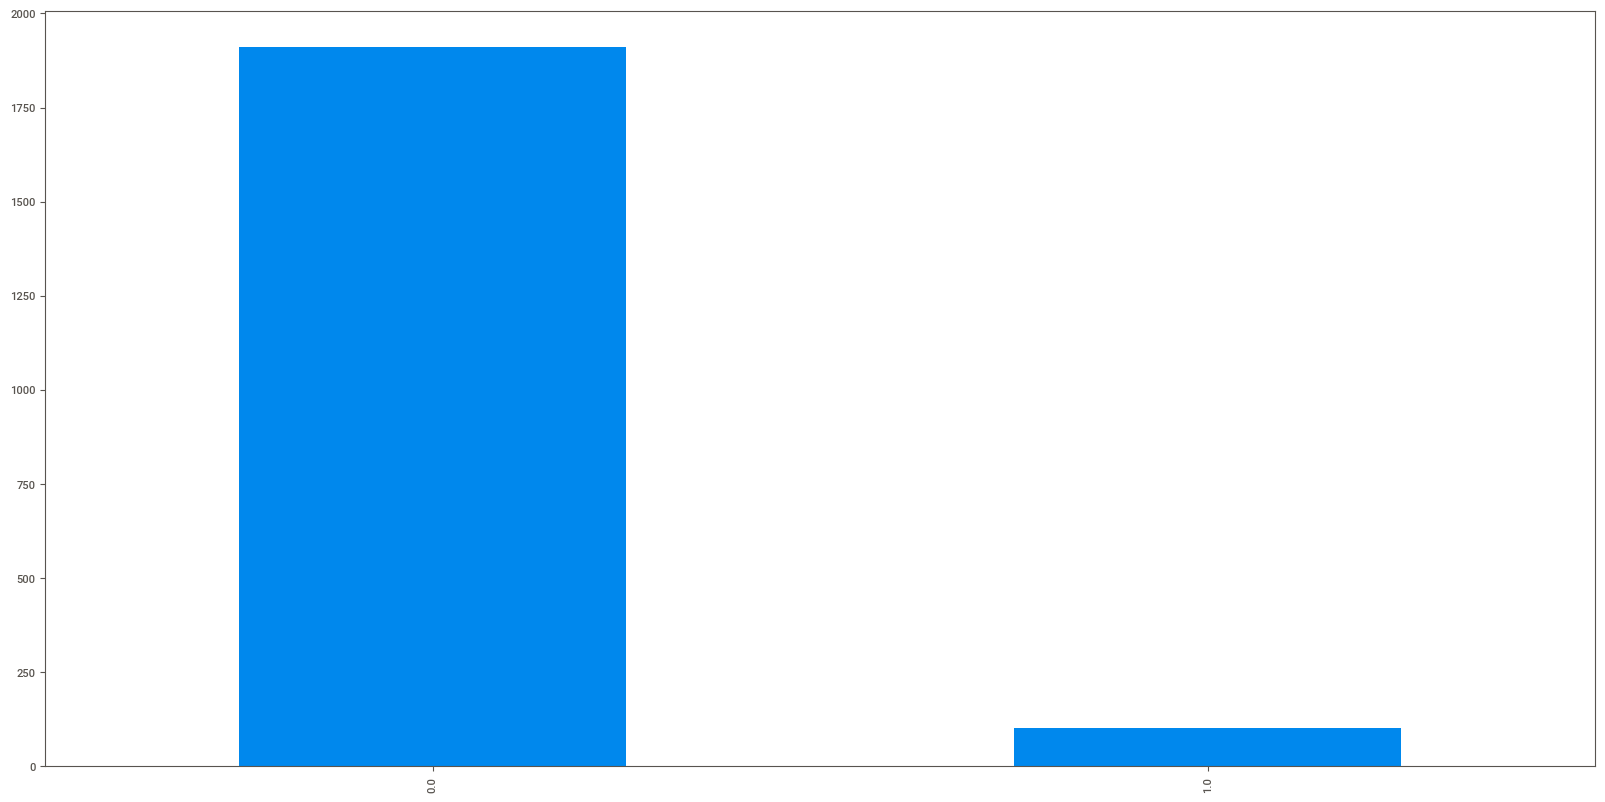

In [63]:
train['outcome'].value_counts().plot(kind = 'bar', figsize = (20,10))

# 5. Feature Selection

In [64]:
distribution_plot = sv.analyze(train)
distribution_plot.show_html('distribution_plot.html')

                                             |                                             | [  0%]   00:00 ->…

Report distribution_plot.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### 5a. According to the sweetviz report, 'evening_proportion' and 'number_of_merchandise' have 1 and 3 distinct values. These 2 features might not bring significance in model building. Therefore, we can drop these 2 features.

In [65]:
train = train.drop(['evening_proportion', 'number_of_merchandise'], axis = 1)
test = test.drop(['evening_proportion', 'number_of_merchandise'], axis = 1)

### 5b. Drop 5 bots that only made 1 bid from train data

<b> '48c528dd6dedf6bdadfeacda9b6df066c8c55', '5c3cf27bce8d533fc726754f01ce163b20337', '2137636448719ca7f3926f8b0df00d2b1ffbb', 'fe36527ed0bcd4ef063c5dfb6e9db7683e168', '52031dece42bc8602c0d7246f57f5c8bcbf69' </b>

In [66]:
# anomolies_bots = ['48c528dd6dedf6bdadfeacda9b6df066c8c55', '5c3cf27bce8d533fc726754f01ce163b20337', 
#                   '2137636448719ca7f3926f8b0df00d2b1ffbb', 'fe36527ed0bcd4ef063c5dfb6e9db7683e168', 
#                   '52031dece42bc8602c0d7246f57f5c8bcbf69']

In [67]:
# train = train[~(train['bidder_id'].isin(anomolies_bots))]

# 6. Model Training

## 6a. Selecting the feature columns

In [68]:
train = train.drop('bidder_id', axis = 1)

In [69]:
X = train.drop('outcome', axis = 1)
y = train['outcome']

In [70]:
X_kaggle = test.drop('bidder_id', axis = 1)

In [71]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1, stratify = y)

In [72]:
# X.to_csv('X_v24.csv', index = None)
# y.to_csv('y_v24.csv', index = None)
# X_kaggle.to_csv('X_kaggle_v24.csv', index = None)

In [73]:
# X = pd.read_csv('X_v22.csv')
# y = pd.read_csv('y_v22.csv')
# X_kaggle = pd.read_csv('X_kaggle_v22.csv')

## 6b. Modelling

### 6bi. Incorporating SMOTE with ExtraTreesClassifier

In [74]:
# define SMOTE sampling
smote = SMOTE(random_state = 1)

# scaler
scaler = StandardScaler()

# define model
extra_model = ExtraTreesClassifier(random_state=1)

# define pipeline
extra_pipeline = Pipeline([('over', smote), ('scaler', scaler), ('model', extra_model)])

# cross_val_score
extra_scores = cross_val_score(extra_pipeline, X, y, scoring ='roc_auc', cv = 5, verbose = 0, n_jobs = -1).mean()

print('Mean AUC for base ExtraTreesClassifier:', round(np.mean(extra_scores), 4))

Mean AUC for base ExtraTreesClassifier: 0.9252


### 6bii. Incorporating SMOTE with LGBMClassifier

In [75]:
# define SMOTE sampling
smote = SMOTE(random_state = 1)

# scaler
scaler = StandardScaler()

# define model
lgbm_model = lgb.LGBMClassifier(random_state=1, learning_rate = 0.1)

# define pipeline
lgbm_pipeline = Pipeline([('over', smote), ('scaler', scaler), ('model', lgbm_model)])

# cross_val_score
lgbm_scores = cross_val_score(lgbm_pipeline, X, y, scoring ='roc_auc', cv = 5, verbose = 0, n_jobs = -1).mean()

print('Mean AUC for base LGBMClassifier:', round(np.mean(lgbm_scores), 4))

Mean AUC for base LGBMClassifier: 0.9104


### 6biii. Incorporating SMOTE with XGBClassifier

In [76]:
# define SMOTE sampling
smote = SMOTE(random_state = 1)

# scaler
scaler = StandardScaler()

# define model
xgb_model = xgb.XGBClassifier(random_state=1, learning_rate = 0.1)

# define pipeline
xgb_pipeline = Pipeline([('over', smote), ('scaler', scaler), ('model', xgb_model)])

# cross_val_score
xgb_scores = cross_val_score(xgb_pipeline, X, y, scoring ='roc_auc', cv = 5, verbose = 0, n_jobs = -1).mean()

print('Mean AUC for base XGBClassifier:', round(np.mean(xgb_scores), 4))

Mean AUC for base XGBClassifier: 0.9102


### 6biv. Incorporating SMOTE with CatBoostClassifier

In [77]:
# define SMOTE sampling
smote = SMOTE(random_state = 1)

# scaler
scaler = StandardScaler()

# define model
cat_model = CatBoostClassifier(random_state=1, learning_rate = 0.1)

# define pipeline
cat_pipeline = Pipeline([('over', smote), ('scaler', scaler), ('model', cat_model)])

# cross_val_score
cat_scores = cross_val_score(cat_pipeline, X, y, scoring ='roc_auc', cv = 5, verbose = 0, n_jobs = -1).mean()

print('Mean AUC for base CatBoostClassifier:', round(np.mean(cat_scores), 4))

Mean AUC for base CatBoostClassifier: 0.898


### 6bv. Incorporating SMOTE with GradientBoostingClassifier

In [78]:
# define SMOTE sampling
smote = SMOTE(random_state = 1)

# scaler
scaler = StandardScaler()

# define model
gbc_model = GradientBoostingClassifier(random_state=1, learning_rate = 0.1)

# define pipeline
gbc_pipeline = Pipeline([('over', smote), ('scaler', scaler), ('model', gbc_model)])

# cross_val_score
gbc_scores = cross_val_score(gbc_pipeline, X, y, scoring ='roc_auc', cv = 5, verbose = 0, n_jobs = -1).mean()

print('Mean AUC for base GradientBoostingClassifier:', round(np.mean(gbc_scores), 4))

Mean AUC for base GradientBoostingClassifier: 0.8841


### 6bvi. Incorporating SMOTE with HistGradientBoostingClassifier

In [79]:
# define SMOTE sampling
smote = SMOTE(random_state = 1)

# scaler
scaler = StandardScaler()

# define model
hgbc_model = HistGradientBoostingClassifier(random_state=1, learning_rate = 0.1)

# define pipeline
hgbc_pipeline = Pipeline([('over', smote), ('scaler', scaler), ('model', hgbc_model)])

# cross_val_score
hgbc_scores = cross_val_score(hgbc_pipeline, X, y, scoring ='roc_auc', cv = 5, verbose = 0, n_jobs = -1).mean()

print('Mean AUC for base HistGradientBoostingClassifier:', round(np.mean(hgbc_scores), 4))

Mean AUC for base HistGradientBoostingClassifier: 0.9012


### 6bvii. Incorporating SMOTE with RandomForestClassifier

In [80]:
# define SMOTE sampling
smote = SMOTE(random_state = 1)

# scaler
scaler = StandardScaler()

# define model
rf_model = RandomForestClassifier(random_state=1)

# define pipeline
rf_pipeline = Pipeline([('over', smote), ('scaler', scaler), ('model', rf_model)])

# cross_val_score
rf_scores = cross_val_score(rf_pipeline, X, y, scoring ='roc_auc', cv = 5, verbose = 0, n_jobs = -1).mean()

print('Mean AUC for base RandomForestClassifier:', round(np.mean(rf_scores), 4))

Mean AUC for base RandomForestClassifier: 0.9121


### 6bviii. Comparing all the models

In [81]:
model_results_dict = {'Model' : ['ExtraTreesClassifier', 'LGBMClassifier', 'XGBClassifier', 'CatBoostClassifier', 'GradientBoostingClassifier', 'HistGradientBoostingClassifier', 'RandomForestClassifier'],
                      'AUC' : [extra_scores, lgbm_scores, xgb_scores, cat_scores, gbc_scores, hgbc_scores, rf_scores]}

models_results = pd.DataFrame(data = model_results_dict)

models_results.sort_values('AUC', ascending = False)

,Model,AUC
0,ExtraTreesClassifier,0.925151
6,RandomForestClassifier,0.912092
1,LGBMClassifier,0.910364
2,XGBClassifier,0.910189
5,HistGradientBoostingClassifier,0.901195
3,CatBoostClassifier,0.897957
4,GradientBoostingClassifier,0.884073


## 6c. Hyperparameter Tuning for ExtraTreesClassifier

### 6ci. Hyperparameter Tuning for ExtraTreesClassifier using RandomGridsearch 

<b>

Good parameters to tune for Extra Trees: <br>

{'n_estimators': [120, 300, 500, 800, 1200], <br>
 'max_depth': [5, 8, 15, 25, 30, None], <br>
 'min_samples_split' : [1, 2, 5, 10, 15, 100], <br>
 'min_samples_leaf': [1, 2, 5, 10], <br>
 'max_features': ['log2', 'sqrt', None]} <br>

</b>

In [82]:
%%time

# define SMOTE sampling
smote = SMOTE(random_state = 1)

# scaler
scaler = StandardScaler()

# create a base model
extra_model = ExtraTreesClassifier(random_state = 1)

# define pipeline
extra_pipeline = Pipeline([('over', smote), ('scaler', scaler), ('model', extra_model)])

# defining parameter range
extra_param_grid = {'model__n_estimators': np.arange(100, 1200, 100),
                    'model__max_depth':  [5, 8, 15, 25, 30, None],
                    'model__min_samples_split' : [1, 2, 5, 10, 15, 100],
                    'model__min_samples_leaf': [1, 2, 5, 10],
                    'model__max_features': ['log2', 'sqrt', None],
                    'model__bootstrap' : [True, False],
                    'model__criterion' : ['gini', 'entropy']}


# Instantiate the grid search model
extra_grid_search = RandomizedSearchCV(estimator = extra_pipeline, 
                                       param_distributions = extra_param_grid,
                                       scoring = 'roc_auc',
                                       cv = 5,
                                       n_iter = 100,
                                       verbose = 0,
                                       n_jobs = -1)

# fit data
extra_grid_search.fit(X, y)

# print best parameter after tuning
print(extra_grid_search.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(extra_grid_search.best_estimator_)

# convert results into a DataFrame
extra_grid_results = pd.DataFrame(extra_grid_search.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]

# cross_val_score
extra_tuned_best_score = extra_grid_search.best_score_

print('Mean AUC for tuned ExtraTreesClassifier:', round(np.mean(extra_tuned_best_score), 4))

{'model__n_estimators': 400, 'model__min_samples_split': 2, 'model__min_samples_leaf': 10, 'model__max_features': None, 'model__max_depth': None, 'model__criterion': 'entropy', 'model__bootstrap': False}
Pipeline(steps=[('over', SMOTE(random_state=1)), ('scaler', StandardScaler()),
                ('model',
                 ExtraTreesClassifier(criterion='entropy', max_features=None,
                                      min_samples_leaf=10, n_estimators=400,
                                      random_state=1))])
Mean AUC for tuned ExtraTreesClassifier: 0.9307
Wall time: 1min 34s


<b>
1. 0.9309 (criterion='entropy', max_features=None,
                                      min_samples_leaf=10, n_estimators=900,
                                      random_state=1)

</b>

In [83]:
# sort by test score
extra_grid_results.sort_values('rank_test_score').head()

,params,mean_test_score,rank_test_score
98,"{'model__n_estimators': 400, 'model__min_sampl...",0.930659,1
39,"{'model__n_estimators': 400, 'model__min_sampl...",0.930636,2
75,"{'model__n_estimators': 700, 'model__min_sampl...",0.930636,2
68,"{'model__n_estimators': 1100, 'model__min_samp...",0.929971,4
64,"{'model__n_estimators': 600, 'model__min_sampl...",0.929412,5


### 6cii. Feature Importance of Tuned ExtraTreesClassifier

In [84]:
# view the feature scores
extra_tuned_feature_scores = pd.Series(extra_grid_search.best_estimator_[2].feature_importances_, index = X_train.columns).sort_values(ascending=False)
extra_tuned_feature_scores

max_number_bids_per_device_per_auct    0.047046
max_number_bids_20min                  0.039590
max_number_bids_30min                  0.038611
max_number_bids_simultaneous           0.036252
max_number_auction_per_ip              0.035944
                                         ...   
max_number_bids_per_url                0.004479
ip_nunique                             0.004196
morning_proportion                     0.003795
afternoon_proportion                   0.003369
min_time_diff                          0.002516
Length: 61, dtype: float64

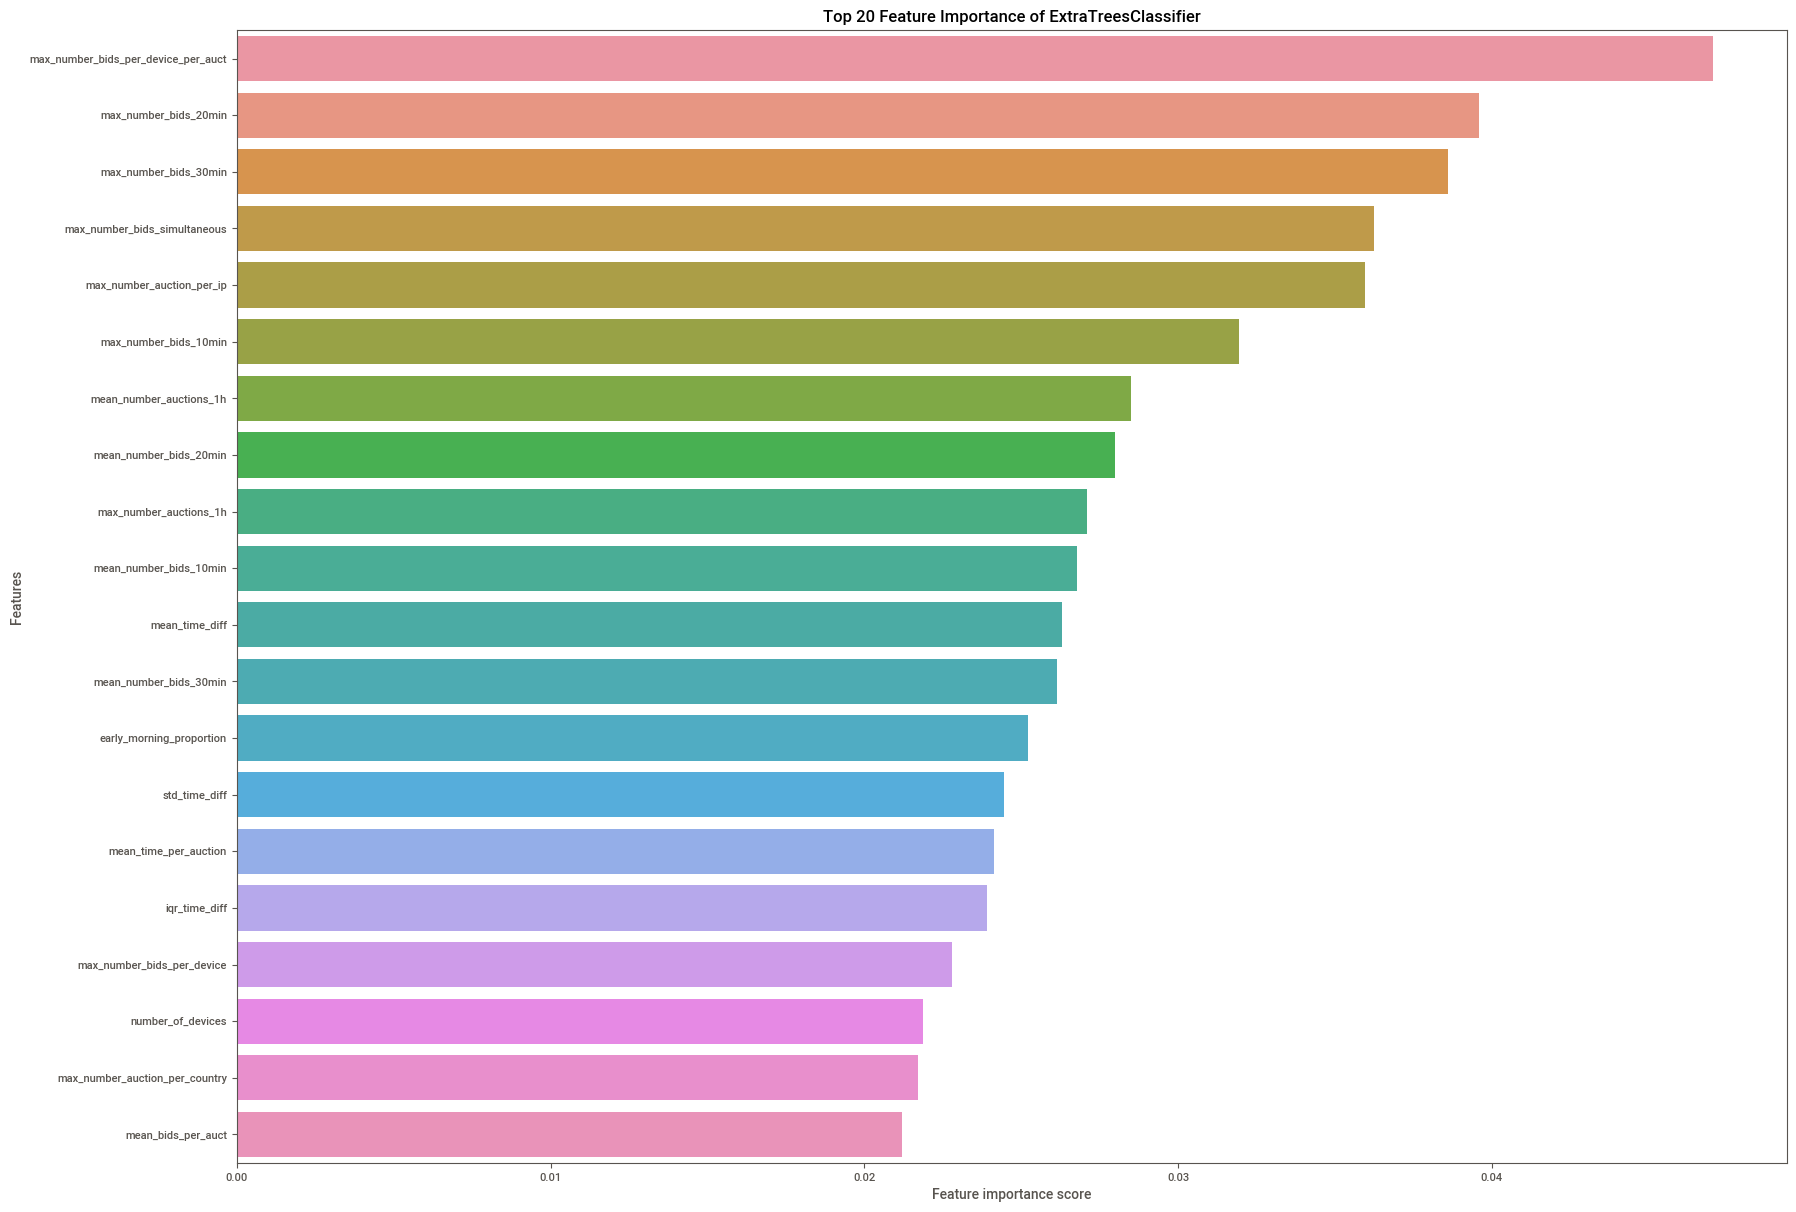

In [85]:
f, ax = plt.subplots(figsize = (20, 15))
ax = sns.barplot(x = extra_tuned_feature_scores[:20], y = extra_tuned_feature_scores.index[:20])
ax.set_title("Top 20 Feature Importance of ExtraTreesClassifier")
ax.set_yticklabels(extra_tuned_feature_scores.index[:20])
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

## 6d. Hyperparameter Tuning for LGBMClassifier

### 6di. Hyperparameter Tuning for LGBMClassifier using RandomGridsearch 

<b>

Good parameters to tune for LightGBM: <br>
1. Decrease max_depth <br>
2. Decrease num_leaves <br>
3. Increase min_gain_to_split <br>
4. Increase min_data_in_leaf and min_sum_hessian_in_leaf <br>
5. Decrease num_iterations <br>

</b>

In [86]:
# %%time

# # define SMOTE sampling
# smote = SMOTE(random_state = 1)

# # scaler
# scaler = StandardScaler()

# # define model
# lgbm_model = lgb.LGBMClassifier(random_state=1, learning_rate = 0.1)

# # define pipeline
# lgbm_pipeline = Pipeline([('over', smote), ('scaler', scaler), ('model', lgbm_model)])

# # defining parameter range
# lgbm_param_grid = {'model__num_leaves': sp_randint(6, 50), 
#                    'model__min_child_samples': sp_randint(100, 500), 
#                    'model__min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
#                    'model__reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
#                    'model__reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}


# # Instantiate the grid search model
# lgbm_grid_search = RandomizedSearchCV(estimator = lgbm_pipeline, 
#                                        param_distributions = lgbm_param_grid,
#                                        scoring = 'roc_auc',
#                                        cv = 5,
#                                        n_iter = 100, # can change to any number
#                                        verbose = 0,
#                                        n_jobs = -1)

# # fit data
# lgbm_grid_search.fit(X, y)

# # print best parameter after tuning
# print(lgbm_grid_search.best_params_)
 
# # print how our model looks after hyper-parameter tuning
# print(lgbm_grid_search.best_estimator_)

# # convert results into a DataFrame
# lgbm_grid_results = pd.DataFrame(lgbm_grid_search.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]

# # cross_val_score
# lgbm_tuned_best_score = lgbm_grid_search.best_score_

# print('Mean AUC for tuned LGBMClassifier:', round(np.mean(lgbm_tuned_best_score), 4))

In [87]:
# # sort by test score
# lgbm_grid_results.sort_values('rank_test_score').head()

### 6dii. Feature Importance of Tuned LGBMClassifier

In [88]:
# # view the feature scores
# lgbm_tuned_feature_scores = pd.Series(lgbm_grid_search.best_estimator_[2].feature_importances_, index = X_train.columns).sort_values(ascending=False)
# lgbm_tuned_feature_scores

In [89]:
# f, ax = plt.subplots(figsize=(20, 15))
# ax = sns.barplot(x = lgbm_tuned_feature_scores[:20], y = lgbm_tuned_feature_scores.index[:20])
# ax.set_title("Top 20 Feature Importance of LGBMClassifier")
# ax.set_yticklabels(lgbm_tuned_feature_scores.index[:20])
# ax.set_xlabel("Feature importance score")
# ax.set_ylabel("Features")
# plt.show()

## 6c. Ensemble ExtraTrees and LightGBM

### 6ci. Soft Voting Classifier 

In [90]:
# %%time

# extra_model = ExtraTreesClassifier(bootstrap=True, criterion='entropy', max_depth=27, max_features='log2', min_samples_leaf=3, min_samples_split=9, n_estimators=200, random_state=1)
# rf_model = RandomForestClassifier(criterion='entropy', max_depth=14, max_features='log2', min_samples_leaf=9, min_samples_split=10, n_estimators=500, random_state=1)

# # create ensemble for improved AUC
# vc = VotingClassifier(estimators = [('model_1', extra_pipeline), ('model_2', rf_pipeline)], 
#                       voting='soft',
#                       weights = [1, 1])

# # cross validation score of
# vc_scores = cross_val_score(vc, X, y, scoring ='roc_auc', cv = 5, verbose = 0, n_jobs = -1).mean()

# print('Mean AUC for base VotingClassifier:', round(np.mean(vc_scores), 4))

### 6cii. Soft Voting Classifier Hyperparameter Tuning

In [91]:
# # define VotingClassifier parameters to search
# vc_params = {'voting':['soft'],
#              'weights':[(1,1), (2,1), (1,2)]}

In [92]:
# %%time

# # find the best set of parameters
# voting_grid = GridSearchCV(vc, vc_params, scoring ='roc_auc', cv = 5, verbose = 0, n_jobs = -1)

# # fit voting classifier with data
# voting_grid.fit(X, y)

# # voting classififer best parameters
# print(voting_grid.best_params_)

# # voting classififer best scores
# print(voting_grid.best_score_)

# 7.Generate and Export Predictions from your Final Model

### 7ai. Use ExtraTreesClassifier grid_search parameters

In [93]:
# # predict_proba with grid search on X_kaggle
# probabilities = extra_grid_search.predict_proba(X_kaggle)

# # Extract values from the rightmost column
# kaggle_preds = probabilities[:,1]
# print(kaggle_preds)

# # create output dataframe
# output_dataframe = pd.DataFrame({'Id': test['bidder_id'],
#                                  'Predicted': kaggle_preds})

# # export output dataframe
# output_dataframe.to_csv('dolapat_prediction_25.csv', index=False)

### 7aii. Hardcode ExtraTreesClassifier parameters

In [96]:
# hardcode final model parameters
final_model = ExtraTreesClassifier(criterion='entropy', max_features=None,
                                      min_samples_leaf=10, n_estimators=900,
                                      random_state=1)

# final_model = extra_grid_search.best_estimator_[2]

# fit final_model
final_model.fit(X, y)

# predict_proba with final model on X_kaggle
probabilities = final_model.predict_proba(X_kaggle)

# Extract values from the rightmost column
kaggle_preds = probabilities[:,1]
print(kaggle_preds)

# create output dataframe
output_dataframe = pd.DataFrame({'Id': test_df['bidder_id'],
                                 'Predicted': kaggle_preds})

# export output dataframe
output_dataframe.to_csv('dolapat_prediction_25.csv', index=False)

[0.         0.0002706  0.10706658 ... 0.10478702 0.00016484 0.04725204]


### 7aiii. Use VotingClassifier grid_search parameters

In [95]:
# # predict_proba with grid search on X_kaggle
# probabilities = voting_grid.predict_proba(X_kaggle)

# # Extract values from the rightmost column
# kaggle_preds = probabilities[:,1]

# # create output dataframe
# output_dataframe = pd.DataFrame({'Id': test['bidder_id'],
#                                  'Predicted': kaggle_preds})

# # export output dataframe
# output_dataframe.to_csv('dolapat_prediction_25.csv', index=False)